In [10]:
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import statsmodels.tsa.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
% matplotlib inline

Suite of Helper functions to automate the preprocessing for each company:

In [2]:
def load_matching_data(path_to_data, key, match_values, chunksize=30000, set_index=True):
    """Reads JSON data from file and extracts subset where key matches match_values."""
    df = pd.read_json(path_to_data, lines=True, orient='columns', chunksize=chunksize)
    final = []
    for chunk in df:
        final.append(chunk[chunk[key].isin(match_values)])
    if set_index:
        return pd.concat(final).set_index(key)
    else:
        return pd.concat(final)

def preprocess(review_filename, user_filename, business_ids):
    """Loads subset data from reviews and users based on Business ID and engineer features."""
    reviews = load_matching_data(review_filename,
                                 key='business_id',
                                 match_values=business_ids,
                                 chunksize=20000)
    customers = reviews.user_id.drop_duplicates().tolist()
    users = load_matching_data(user_filename,
                               key='user_id',
                               match_values=customers,
                               chunksize=20000)

    df = reviews.merge(users, how='left', left_on='user_id', right_index=True)
    
    # engineer features
    df['year'] = df.date.dt.year.astype(str)
    df['is_elite'] = [x in y for x, y in zip(df.year.tolist(), df.elite.tolist())]
    df['influence'] = df.is_elite.astype(int) * 100\
                        + df.useful_x + df.funny_x \
                        + df.cool_x + df.fans + 1 # +1 to include count of reviews

    top5pct = int(0.05 * users.shape[0])
    # take top 5% by total review influence as influencers
    influencers = df.groupby('user_id')['influence'].sum()\
                    .sort_values(ascending=False)[:top5pct]\
                    .index.tolist()
    # control for star ratings
    df['adj_stars'] = df.stars - df.average_stars
    df['influencer_rating'] = df.user_id.isin(influencers) * df.adj_stars # adjust for avg stars
    
    # use NLTK's Vader function to provide sentiment polarity score
    df.date = df.date.dt.date
    nlp = SentimentIntensityAnalyzer()
    df['sentiment'] = df.text.apply(lambda x: nlp.polarity_scores(x)['compound'])
    return df

def preprocess_checkins(checkin_filename, business_ids):
    """Loads subset of data from check-ins and preprocesses it to daily count."""
    checkins = load_matching_data(checkin_filename, 
                                  key='business_id',
                                  match_values=business_ids,
                                  chunksize=20000,
                                  set_index=False)
    # split into list of checkin dates
    checkins.date = checkins.date.str.split(', ')
    checkin_times = pd.DataFrame(pd.to_datetime(checkins.date.sum()),
                                 columns=['datetime'])
    checkin_times['dummy'] = 1
    checkin_times['date'] = checkin_times.datetime.dt.date
    # count number of checkins per day
    checkin_times = checkin_times.groupby('date')['dummy'].sum()\
                                .asfreq('D').fillna(0.)
    return checkin_times

def create_endog_variables(df, checkins):
    """Helper function to combine predictor features and check-ins data."""
    endog = df.groupby('date').agg({'adj_stars':np.mean,
                                    'sentiment':np.mean,
                                    'influencer_rating':np.sum})
    endog = endog.asfreq('D').fillna(0.0)
    endog['checkins'] = checkins
    endog = endog.dropna()
    return endog

def test_endog_stationary(endog):
    """Applies ADF test to each column in endog, and tests on differenced data if necessary."""
    for col in endog.columns:
        diff = 0
        pval = sm.stattools.adfuller(endog[col], maxlag=180)[1]
        if pval > 0.001:
            # apply 1-step differencing to detrend
            diff+=1
            pval = sm.stattools.adfuller(endog[col].diff()[1:], maxlag=180)[1]
        print("{} - Diff: {}, P-val: {}".format(col, diff, pval))
    return

def plot_endog_acf(endog):
    # ACF of endogeneous variables
    fig = plt.figure(figsize=(10,8))
    layout = (2,2)
    lags=30
    ax1 = plt.subplot2grid(layout, (0,0))
    ax2 = plt.subplot2grid(layout, (0,1))
    ax3 = plt.subplot2grid(layout, (1,0))
    ax4 = plt.subplot2grid(layout, (1,1))

    sm.graphics.plot_acf(endog.checkins, ax=ax1, lags=lags, title='Check-ins')
    sm.graphics.plot_acf(endog.adj_stars, ax=ax2, lags=lags, title='Adjusted Stars')
    sm.graphics.plot_acf(endog.sentiment, ax=ax3, lags=lags, title='Sentiment')
    sm.graphics.plot_acf(endog.influencer_rating, ax=ax4, lags=lags, title='Influencer Rating')

    plt.tight_layout()
    plt.show(block=False)
    
def fit_VAR_with_granger_test(endog):
    """Fit a VAR model to endog, printing order selection and necessary tests of the results."""
    model = sm.VAR(endog.dropna())
    order = model.select_order()
    print(order.summary())
    print("Selecting order of {} using AIC...".format(order.aic))
    results = model.fit(maxlags=order.aic, ic='aic', trend='c')
    print("Model coefficients are stable: {}".format(results.is_stable()))
    print()
    print(results.test_whiteness(nlags=14, adjusted=True).summary())
    print()
    print(results.test_causality(3, causing=[0,1,2]).summary())
    print()
    print(results.test_inst_causality([0,1,2]).summary())
    return results

Load the following code for obtaining business data on In-N-Out Burger, Shake Shack and The Cheesecake Factory:

In [3]:
# for reading in raw json
business = pd.read_json('yelp_dataset/business.json', lines=True, orient='columns')
business.set_index('business_id', inplace=True)
business.head()

,address,attributes,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
business_id,,,,,,,,,,,,,
1SWheh84yJXfytovILXOAQ,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
QXAEGFB4oINsVuTFxEYKFQ,30 Eglinton Avenue W,"{'HasTV': 'False', 'RestaurantsTableService': ...","Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Thursday': '9:0-0:0', 'Wednesday': '9:0-0:0'...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
gnKjwL_1w79qoiV3IC_xQQ,"10110 Johnston Rd, Ste 15","{'HasTV': 'True', 'RestaurantsTableService': '...","Sushi Bars, Restaurants, Japanese",Charlotte,"{'Thursday': '17:30-21:30', 'Wednesday': '17:3...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
xvX2CttrVhyG2z1dFg_0xw,"15655 W Roosevelt St, Ste 237",None,"Insurance, Financial Services",Goodyear,"{'Friday': '8:0-17:0', 'Thursday': '8:0-17:0',...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
HhyxOkGAM07SRYtlQ4wMFQ,"4209 Stuart Andrew Blvd, Ste F","{'ByAppointmentOnly': 'True', 'BusinessAccepts...","Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Thursday': '7:0-23:0', 'Wednesday': '7:0-23:...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


In [4]:
cheesecake = business[business.name == 'The Cheesecake Factory']
shakeshack = business[business.name == 'Shake Shack']
innout = business[business.name == 'In-N-Out Burger']

# EDA plots for slides

In [5]:
# load checkins for in n out
checkins = load_matching_data('./yelp_dataset/checkin.json', 
                              key='business_id',
                              match_values=innout.index.tolist(),
                              chunksize=20000,
                              set_index=False)
# load day of week plot
checkins.date = checkins.date.str.split(', ')
checkins_dayofweek = pd.to_datetime(checkins.date.sum()).dayofweek.value_counts() # sat and sun top
checkins_dayofweek = checkins_dayofweek.reindex(index=range(7))\
                    .rename(index=dict(zip(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])))

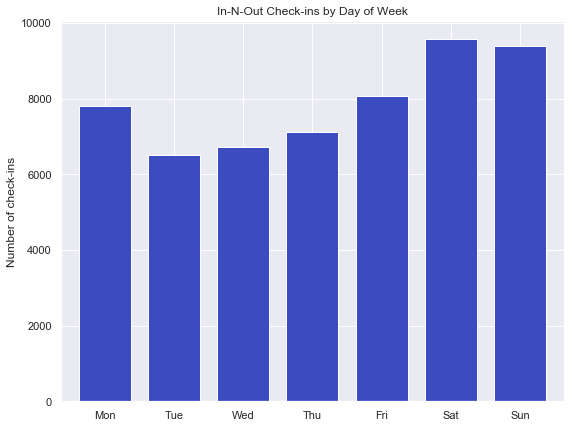

In [6]:
checkins_dayofweek.plot.bar(rot=0, figsize=(9,7), width=0.75, cmap='coolwarm');
plt.ylabel('Number of check-ins')
plt.title('In-N-Out Check-ins by Day of Week');

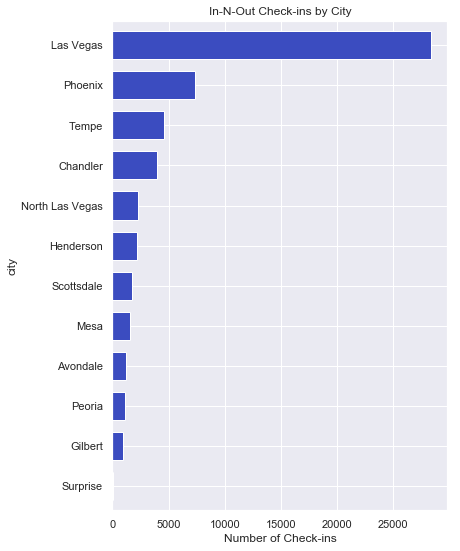

In [7]:
checkins['count'] = checkins.date.apply(len)

# plot checkins by city location
business.merge(checkins, 'inner', left_index=True, right_on='business_id')\
        .groupby('city')['count'].sum().sort_values(ascending=True).plot.barh(figsize=(6,9), 
                                                                              cmap='coolwarm',
                                                                              width=0.7);
plt.xlabel('Number of Check-ins');
plt.title('In-N-Out Check-ins by City');

# In-N-Out

Get all business Ids, get all reviews on all business locations and join.

In [8]:
# get all requisite data, takes a while
df_innout = preprocess('yelp_dataset/review.json', 'yelp_dataset/user.json', innout.index.tolist())
checkin_times = preprocess_checkins('./yelp_dataset/checkin.json', innout.index.tolist())

In [11]:
endog = create_endog_variables(df_innout, checkin_times)

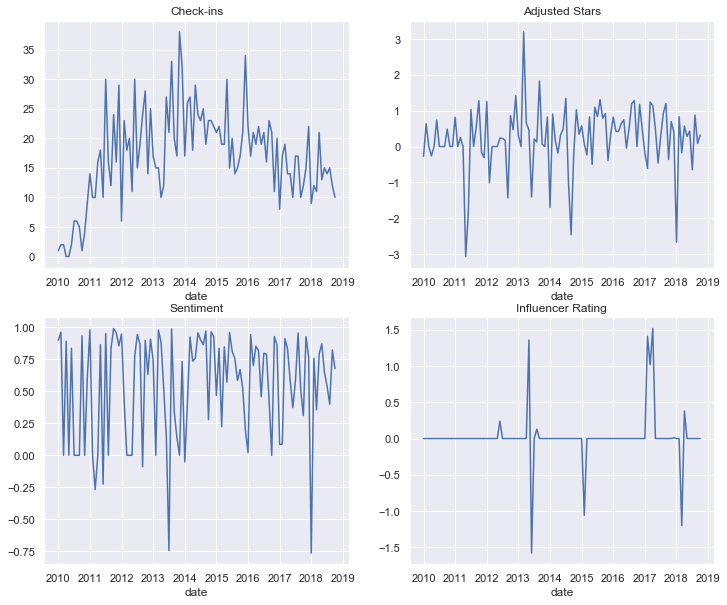

In [12]:
# Quick overview of endogeneous variables
plt.figure(1, figsize=(12,10))
plt.subplot(221)
endog.asfreq('M').checkins.plot()
plt.title('Check-ins');

plt.subplot(222)
endog.asfreq('M').adj_stars.plot()
plt.title('Adjusted Stars');

plt.subplot(223)
endog.asfreq('M').sentiment.plot()
plt.title('Sentiment');

plt.subplot(224)
endog.asfreq('M').influencer_rating.plot()
plt.title('Influencer Rating');

## Check stationarity

In [13]:
test_endog_stationary(endog)

influencer_rating - Diff: 0, P-val: 0.0
sentiment - Diff: 1, P-val: 5.926362470358938e-24
adj_stars - Diff: 0, P-val: 0.0
checkins - Diff: 1, P-val: 3.1288599529308036e-19


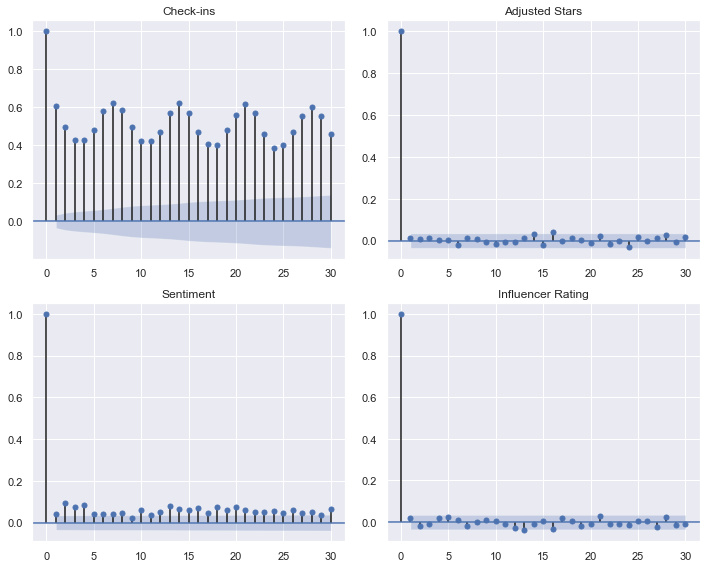

In [14]:
plot_endog_acf(endog)

In [15]:
# remove seasonality naively
decomposed = sm.seasonal_decompose(endog.checkins)

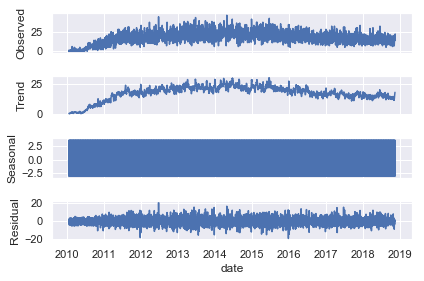

In [16]:
decomposed.plot();

In [17]:
endog.checkins = decomposed.trend

In [18]:
# Difference those that need to be detrended
endog.sentiment = endog.sentiment.diff()
endog.checkins = endog.checkins.diff()

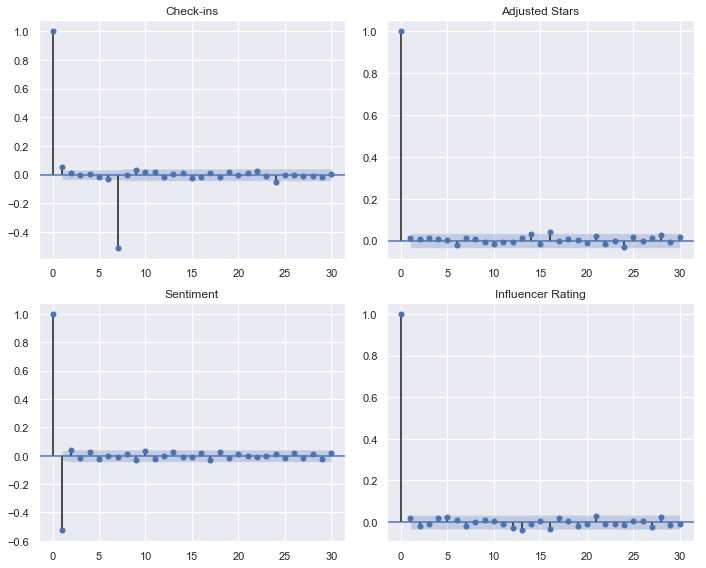

In [19]:
plot_endog_acf(endog.dropna())

It seems that the data is roughly stationary, with the exception of possible MA terms. As we are only using VAR models, we will ignore it and simply proceed with this transformed data.

## Model and tests

In [20]:
innout_res = fit_VAR_with_granger_test(endog)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -3.843      -3.836     0.02142      -3.840
1       -4.244      -4.206     0.01434      -4.231
2       -4.364      -4.295     0.01273      -4.339
3       -4.424      -4.325     0.01198      -4.389
4       -4.459      -4.330     0.01157      -4.413
5       -4.487      -4.327     0.01125      -4.430
6       -4.497      -4.307     0.01114      -4.429
7       -4.810     -4.589*    0.008148      -4.731
8       -4.815      -4.563    0.008110      -4.725
9       -4.823      -4.541    0.008042      -4.722
10      -4.822      -4.510    0.008052      -4.710
11      -4.825      -4.482    0.008026      -4.702
12      -4.833      -4.460    0.007964      -4.699
13      -4.835      -4.431    0.007947      -4.690
14      -4.957      -4.523    0.007031     -4.802*
15      -4.957      -4.493    0.007032      -4.791
16      -4.957      -4.462    0

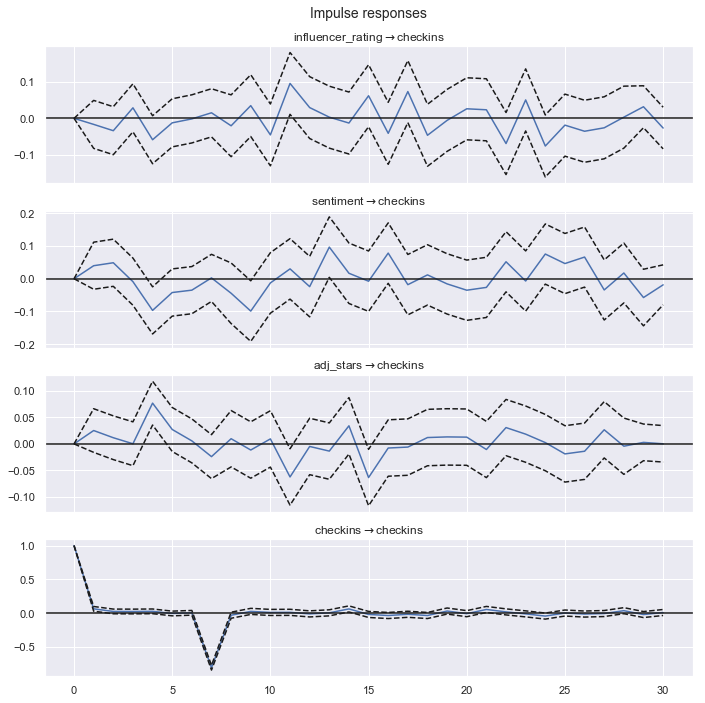

In [21]:
irf = innout_res.irf(periods=30)
irf.plot(orth=False, response='checkins', seed=12345);

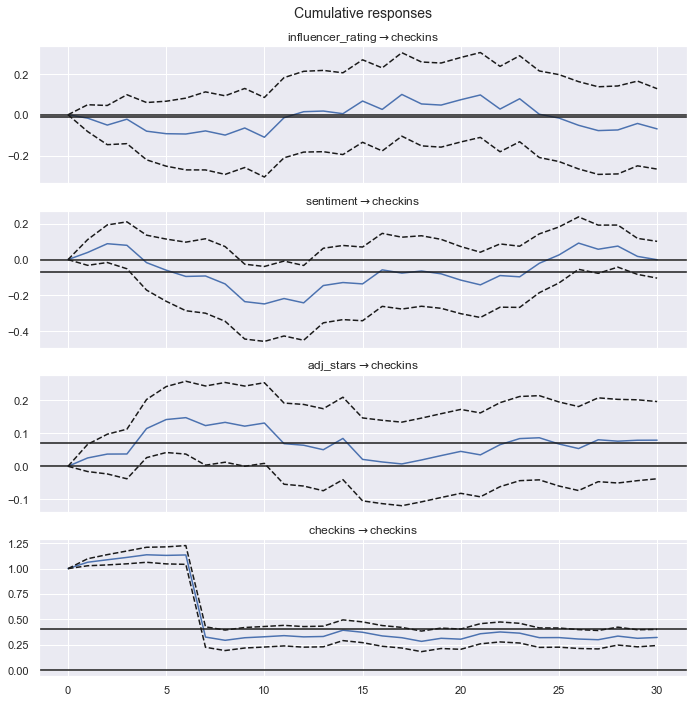

In [22]:
irf.plot_cum_effects(response='checkins', seed=12345);

# Shake Shack

In [23]:
# get all requisite data, takes a while
df_shake = preprocess('yelp_dataset/review.json', 'yelp_dataset/user.json', shakeshack.index.tolist())
shake_checkin_times = preprocess_checkins('./yelp_dataset/checkin.json', shakeshack.index.tolist())

In [24]:
endog = create_endog_variables(df_shake, shake_checkin_times)

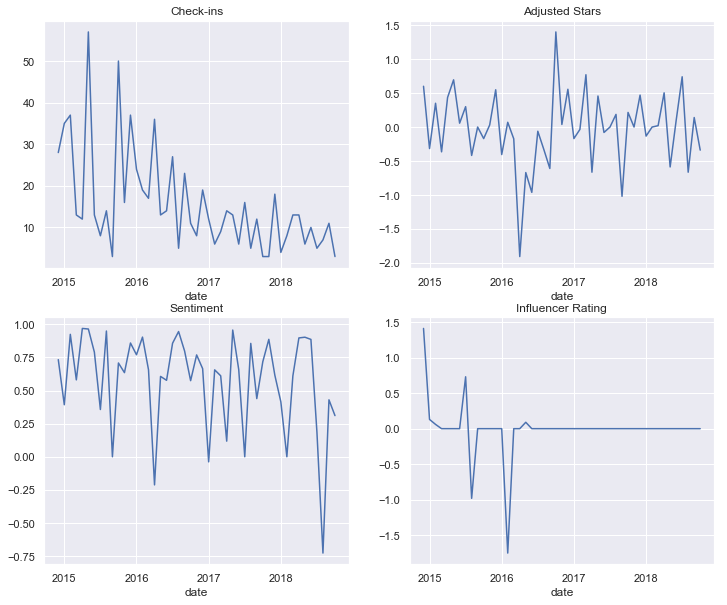

In [25]:
# Quick overview of endogeneous variables
plt.figure(1, figsize=(12,10))
plt.subplot(221)
endog.asfreq('M').checkins.plot()
plt.title('Check-ins');

plt.subplot(222)
endog.asfreq('M').adj_stars.plot()
plt.title('Adjusted Stars');

plt.subplot(223)
endog.asfreq('M').sentiment.plot()
plt.title('Sentiment');

plt.subplot(224)
endog.asfreq('M').influencer_rating.plot()
plt.title('Influencer Rating');

## Check stationarity

In [26]:
test_endog_stationary(endog)

influencer_rating - Diff: 0, P-val: 8.20184669479371e-14
sentiment - Diff: 0, P-val: 0.0
adj_stars - Diff: 0, P-val: 0.0
checkins - Diff: 1, P-val: 1.0379278248391083e-10


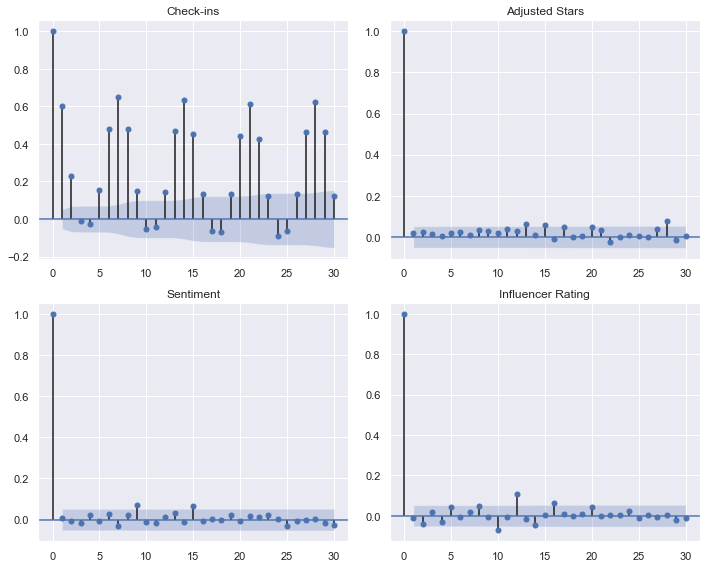

In [27]:
plot_endog_acf(endog)

There appears to be seasonality in Check-ins with a period of 7 days. Thus need to deseasonalize as per In-N-Out.

In [28]:
decomposed = sm.seasonal_decompose(endog.checkins)

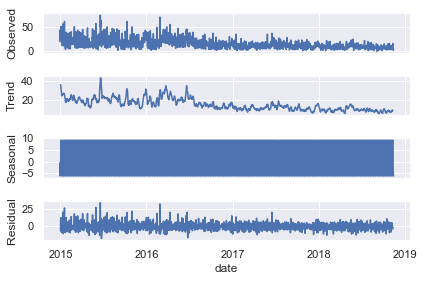

In [29]:
decomposed.plot();

In [30]:
endog.checkins = decomposed.trend.diff() # detrend check-ins as well

Re-test and visualize:

In [31]:
test_endog_stationary(endog.dropna())

influencer_rating - Diff: 0, P-val: 6.652750826839889e-14
sentiment - Diff: 0, P-val: 0.0
adj_stars - Diff: 0, P-val: 0.0
checkins - Diff: 0, P-val: 4.690338576574207e-09


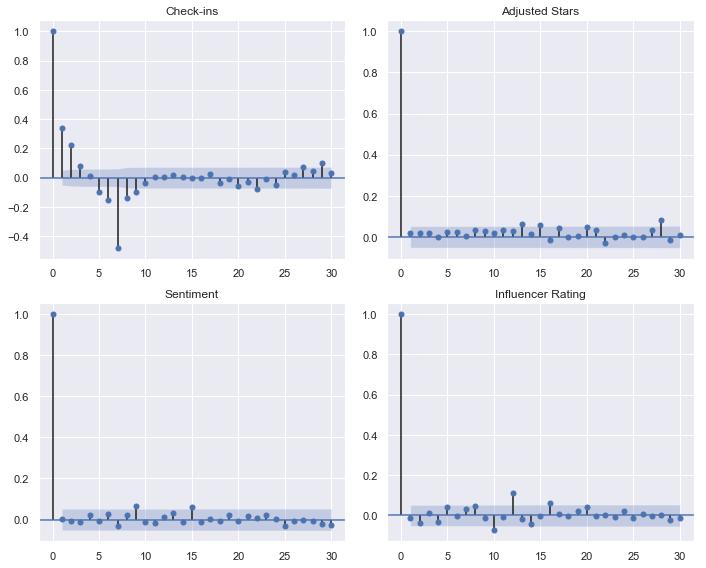

In [32]:
plot_endog_acf(endog.dropna())

There is still some autocorrelation after removing seasonality and trend. This seems to imply that MA terms should be included in the model specifications. However, since we are using VAR, we accept this as a model limitation instead.

## Model and tests

In [33]:
results = fit_VAR_with_granger_test(endog)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -4.849      -4.834    0.007839      -4.843
1       -4.955     -4.880*    0.007046      -4.927
2       -4.955      -4.819    0.007049      -4.904
3       -4.944      -4.748    0.007125      -4.871
4       -4.939      -4.683    0.007159      -4.843
5       -4.942      -4.625    0.007140      -4.824
6       -4.941      -4.563    0.007150      -4.799
7       -5.148      -4.710    0.005813      -4.984
8       -5.183      -4.685    0.005613     -4.996*
9       -5.190      -4.632    0.005571      -4.981
10      -5.180      -4.561    0.005629      -4.948
11      -5.166      -4.487    0.005706      -4.912
12      -5.176      -4.436    0.005654      -4.899
13      -5.171      -4.370    0.005682      -4.871
14      -5.249      -4.389    0.005252      -4.928
15     -5.268*      -4.347   0.005155*      -4.924
16      -5.259      -4.278    0

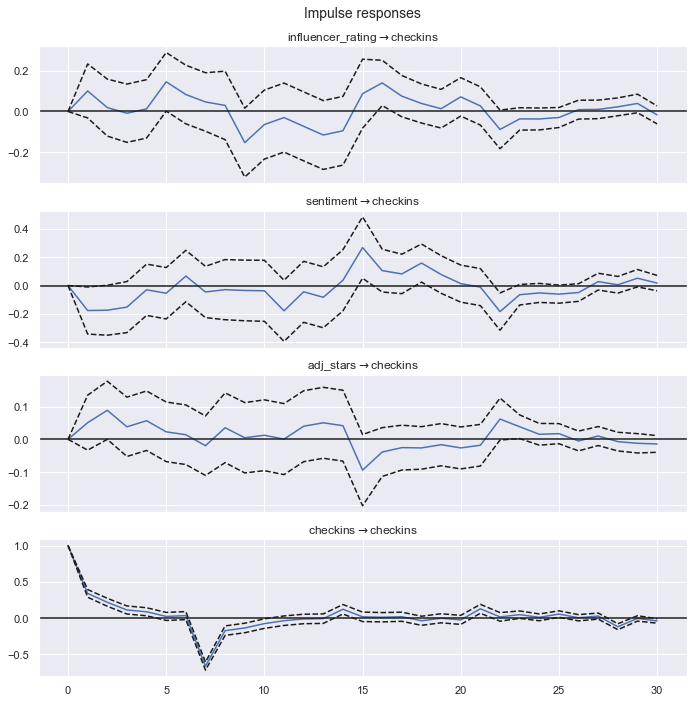

In [34]:
irf = results.irf(periods=30)
irf.plot(orth=False, response='checkins', seed=12345);

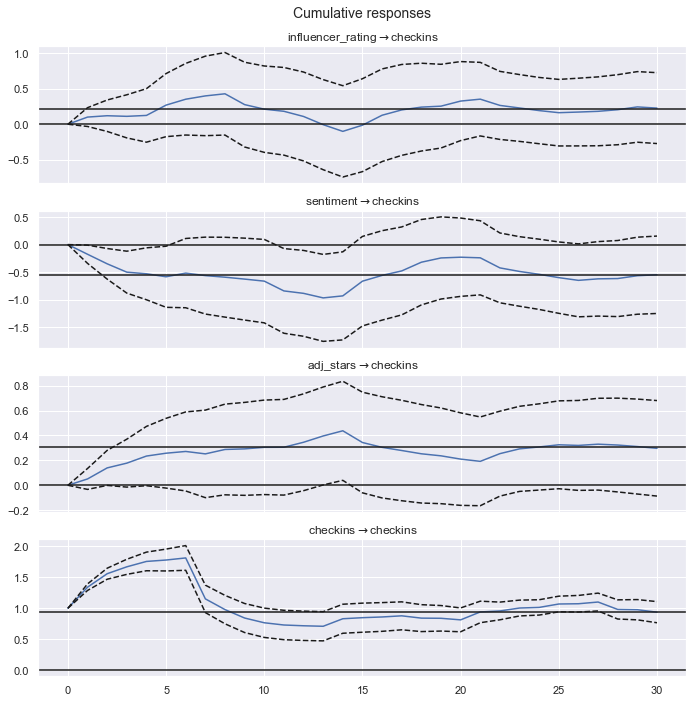

In [35]:
# cumulative effects over time per unit impulse
irf.plot_cum_effects(orth=False, response='checkins', seed=12345);

# Cheesecake Factory

In [36]:
df_cheese = preprocess('yelp_dataset/review.json', 'yelp_dataset/user.json', cheesecake.index.tolist())
cheese_checkin_times = preprocess_checkins('./yelp_dataset/checkin.json', cheesecake.index.tolist())

In [37]:
endog = create_endog_variables(df_cheese, cheese_checkin_times)

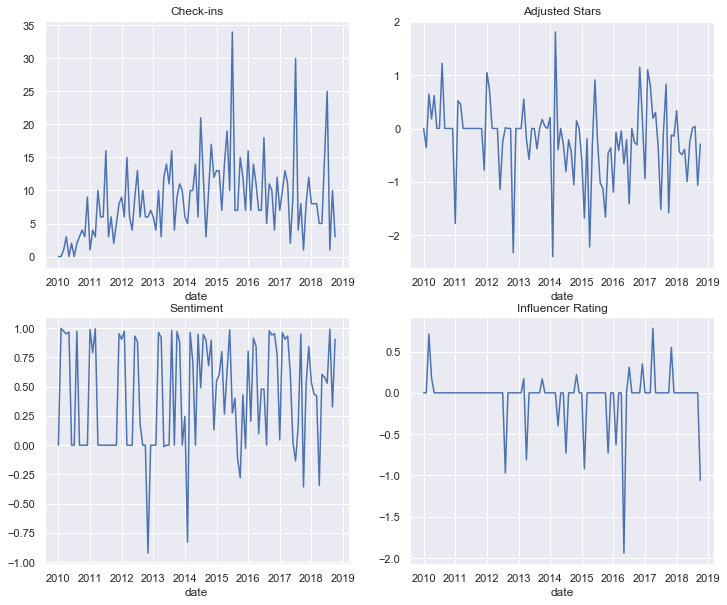

In [38]:
# Quick overview of endogeneous variables
plt.figure(1, figsize=(12,10))
plt.subplot(221)
endog.asfreq('M').checkins.plot()
plt.title('Check-ins');

plt.subplot(222)
endog.asfreq('M').adj_stars.plot()
plt.title('Adjusted Stars');

plt.subplot(223)
endog.asfreq('M').sentiment.plot()
plt.title('Sentiment');

plt.subplot(224)
endog.asfreq('M').influencer_rating.plot()
plt.title('Influencer Rating');

## Check Stationarity

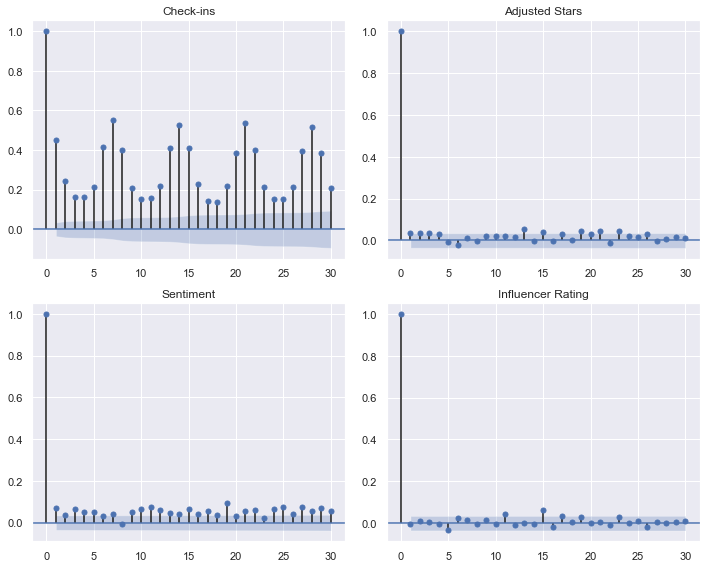

In [39]:
plot_endog_acf(endog)

In [40]:
decomposed = sm.seasonal_decompose(endog.checkins)

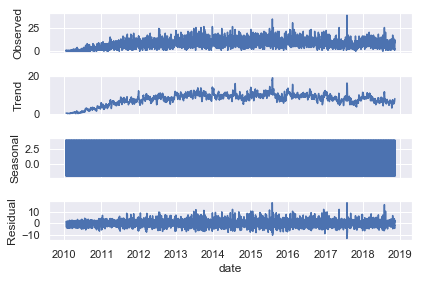

In [41]:
decomposed.plot();

In [42]:
endog.checkins = decomposed.trend

In [43]:
test_endog_stationary(endog.dropna())

influencer_rating - Diff: 0, P-val: 0.0
sentiment - Diff: 0, P-val: 8.664449752571315e-08
adj_stars - Diff: 0, P-val: 6.284840609212301e-16
checkins - Diff: 1, P-val: 6.621064750165182e-12


In [44]:
endog.checkins = endog.checkins.diff()

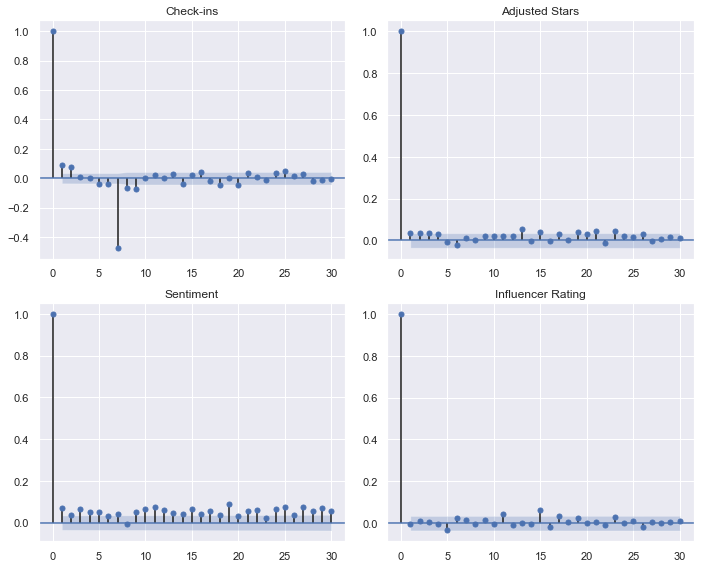

In [45]:
plot_endog_acf(endog.dropna())

## Model and tests

In [46]:
results = fit_VAR_with_granger_test(endog)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -5.110      -5.103    0.006034      -5.108
1       -5.120      -5.082    0.005979      -5.106
2       -5.123      -5.054    0.005958      -5.098
3       -5.122      -5.023    0.005966      -5.086
4       -5.120      -4.991    0.005975      -5.074
5       -5.123      -4.963    0.005957      -5.066
6       -5.125      -4.935    0.005946      -5.057
7       -5.368     -5.147*    0.004663      -5.289
8       -5.364      -5.113    0.004681      -5.274
9       -5.360      -5.078    0.004703      -5.259
10      -5.355      -5.043    0.004722      -5.244
11      -5.354      -5.011    0.004729      -5.231
12      -5.351      -4.977    0.004745      -5.217
13      -5.351      -4.948    0.004743      -5.206
14      -5.478      -5.044    0.004176     -5.323*
15      -5.481      -5.016    0.004167      -5.314
16      -5.474      -4.979    0

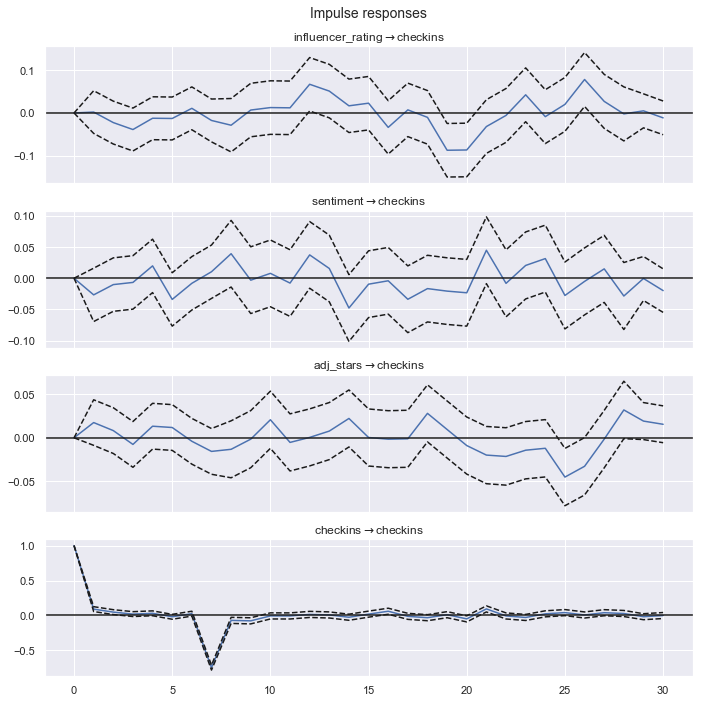

In [47]:
irf = results.irf(periods=30)
irf.plot(orth=False, response='checkins', seed=12345);

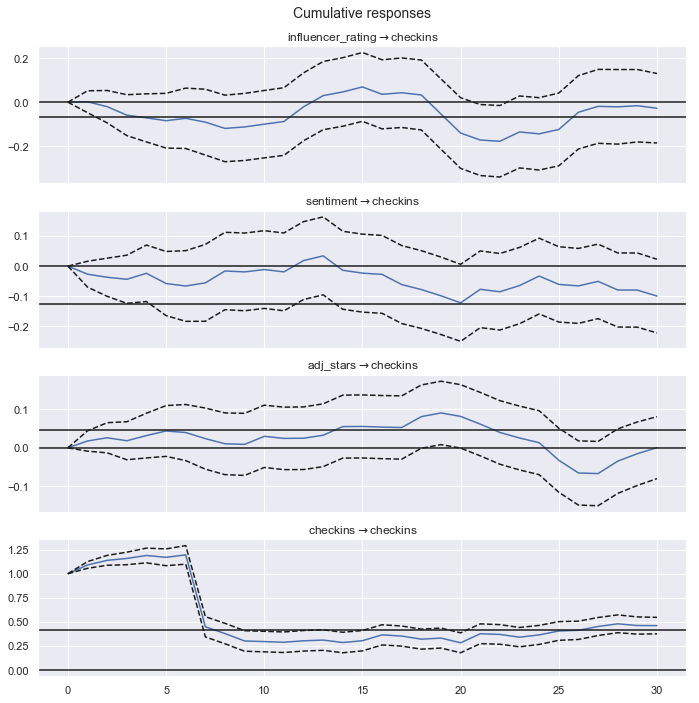

In [48]:
irf.plot_cum_effects(orth=False, response='checkins', seed=12345);